<a href="https://colab.research.google.com/github/markumreed/health_disparities_role_of_gen_ai/blob/main/ccda_and_trends_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧬 Health Disparities & AI: CCDA Generator + Google Trends Tracker
Generate synthetic CCDA patient records and track public interest trends on AI in healthcare.

In [19]:
!pip install faker lxml pytrends ace_tools

In [2]:
import pandas as pd
import random
from faker import Faker
from lxml import etree
from pytrends.request import TrendReq
from pytrends import exceptions
from IPython.display import display, Markdown
import time

# Setup
fake = Faker()
ethnicities = ["Black", "White", "Hispanic", "Asian", "AIAN", "NHPI"]
CCDA_CODES = {
    "demographics": "21112-8",
    "social_history": "29762-2",
    "conditions": "11450-4",
    "medications": "10160-0",
    "procedures": "47519-4"
}


In [3]:
# Load dataset
df = pd.read_csv("healthcare_dataset.csv")
df.head()


,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal


In [17]:
df['Medical Condition'].unique()

array(['Cancer', 'Obesity', 'Diabetes', 'Asthma', 'Hypertension',
       'Arthritis'], dtype=object)

In [21]:
import random

# Define symptom descriptions for each condition
symptoms_dict = {
    "Cancer": [
        "Unexplained weight loss", "Fatigue", "Persistent pain",
        "Skin changes", "Lumps or thickening", "Persistent cough"
    ],
    "Obesity": [
        "Excessive body fat", "Shortness of breath", "Joint pain",
        "Fatigue", "Sleep apnea", "Skin irritation"
    ],
    "Diabetes": [
        "Increased thirst", "Frequent urination", "Fatigue",
        "Blurred vision", "Slow-healing wounds", "Tingling in extremities"
    ],
    "Asthma": [
        "Shortness of breath", "Wheezing", "Chest tightness",
        "Coughing at night", "Rapid breathing", "Fatigue during exercise"
    ],
    "Hypertension": [
        "Often asymptomatic", "Headaches", "Dizziness",
        "Nosebleeds", "Vision issues", "Chest pain"
    ],
    "Arthritis": [
        "Joint pain", "Stiffness", "Swelling in joints",
        "Redness", "Decreased range of motion", "Morning stiffness"
    ]
}

# Function to generate a fake clinic note
def generate_clinic_note(row):
    condition = row['Medical Condition']
    symptoms = random.sample(symptoms_dict.get(condition, []), 3)
    note = (
        f"Patient presents with symptoms including {', '.join(symptoms)}. "
        f"Condition consistent with {condition}. "
        f"Prescribed medication: {row['Medication']}. "
        f"Follow-up scheduled post-discharge on {pd.to_datetime(row['Discharge Date']) + pd.Timedelta(days=30)}."
    )
    return note

# Apply the function to generate notes
df['Clinic Note'] = df.apply(generate_clinic_note, axis=1)

# Show sample with notes

df.head()


,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results,Clinic Note
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal,Patient presents with symptoms including Fatig...
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive,Patient presents with symptoms including Fatig...
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal,Patient presents with symptoms including Skin ...
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal,Patient presents with symptoms including Frequ...
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal,Patient presents with symptoms including Persi...


In [24]:
CCDA_CODES = {
    "demographics": "10160-0",
    "social_history": "29762-2",
    "conditions": "11450-4",
    "medications": "10160-0",
    "procedures": "47519-4",
    "clinic_notes": "34109-9"  # Example LOINC code for progress note
}

def create_ccda_from_row(row):
    root = etree.Element("ClinicalDocument")

    # Demographics section
    demo = etree.SubElement(root, "section", code=CCDA_CODES["demographics"])
    etree.SubElement(demo, "name").text = row["Name"].title()
    etree.SubElement(demo, "age").text = str(row["Age"])
    etree.SubElement(demo, "gender").text = row["Gender"]
    etree.SubElement(demo, "blood_type").text = row["Blood Type"]
    etree.SubElement(demo, "ethnicity").text = random.choice(ethnicities)

    # Social history section
    social = etree.SubElement(root, "section", code=CCDA_CODES["social_history"])
    etree.SubElement(social, "insurance").text = row["Insurance Provider"]
    etree.SubElement(social, "admission_type").text = row["Admission Type"]
    etree.SubElement(social, "billing_amount").text = f"{row['Billing Amount']:.2f}"

    # Medical conditions section
    conditions = etree.SubElement(root, "section", code=CCDA_CODES["conditions"])
    etree.SubElement(conditions, "condition").text = row["Medical Condition"]
    etree.SubElement(conditions, "test_result").text = row["Test Results"]

    # Medications section
    meds = etree.SubElement(root, "section", code=CCDA_CODES["medications"])
    etree.SubElement(meds, "medication").text = row["Medication"]

    # Procedures section
    procs = etree.SubElement(root, "section", code=CCDA_CODES["procedures"])
    etree.SubElement(procs, "procedure").text = f"Admitted on {row['Date of Admission']} for {row['Admission Type']}"

    # Clinic notes section
    notes = etree.SubElement(root, "section", code=CCDA_CODES["clinic_notes"])
    etree.SubElement(notes, "note").text = row["Clinic Note"]

    return etree.tostring(root, pretty_print=True).decode("utf-8")



In [25]:
# Generate and display a sample XML
sample_xml = create_ccda_from_row(df.iloc[0])
print(sample_xml)


<ClinicalDocument>
  <section code="10160-0">
    <name>Bobby Jackson</name>
    <age>30</age>
    <gender>Male</gender>
    <blood_type>B-</blood_type>
    <ethnicity>NHPI</ethnicity>
  </section>
  <section code="29762-2">
    <insurance>Blue Cross</insurance>
    <admission_type>Urgent</admission_type>
    <billing_amount>18856.28</billing_amount>
  </section>
  <section code="11450-4">
    <condition>Cancer</condition>
    <test_result>Normal</test_result>
  </section>
  <section code="10160-0">
    <medication>Paracetamol</medication>
  </section>
  <section code="47519-4">
    <procedure>Admitted on 2024-01-31 for Urgent</procedure>
  </section>
  <section code="34109-9">
    <note>Patient presents with symptoms including Fatigue, Persistent cough, Unexplained weight loss. Condition consistent with Cancer. Prescribed medication: Paracetamol. Follow-up scheduled post-discharge on 2024-03-03 00:00:00.</note>
  </section>
</ClinicalDocument>



## 📢 Important Note on Google Trends Data
The Python package pytrends is currently not working due to issues connecting to the Google Trends API. As a result, you will need to manually download your data from the Google Trends website.
Please ensure you download the CSV file for your selected keywords and time range directly from the site and upload it to your project accordingly.

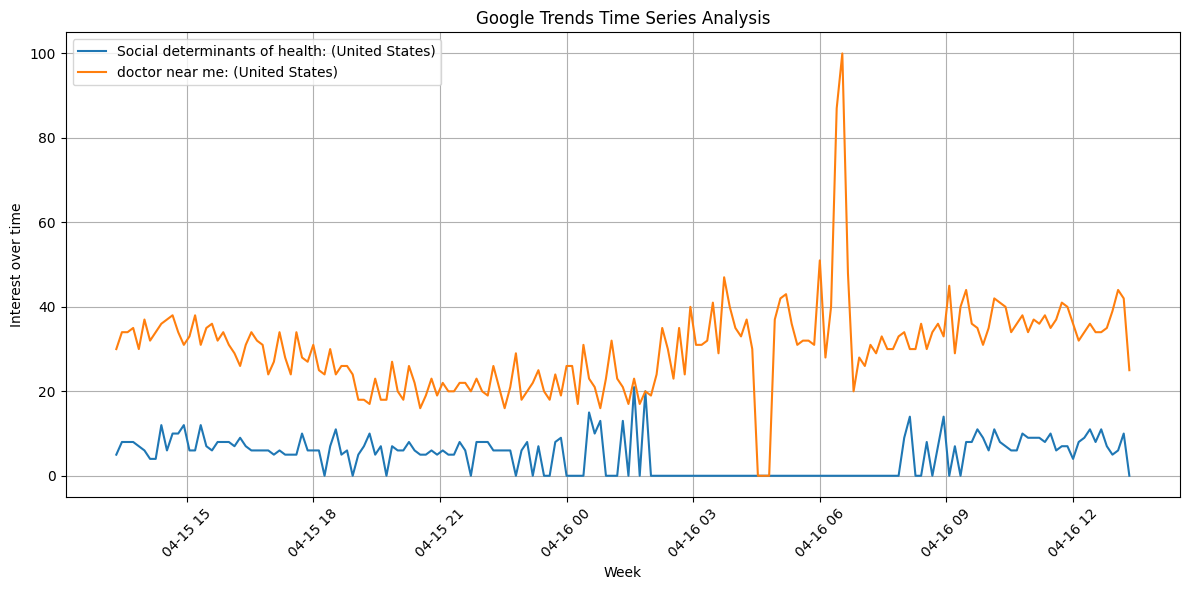

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the multiTimeline.csv file into a pandas DataFrame.
# Replace 'multiTimeline.csv' with the actual file name if different.
try:
    df_trends = pd.read_csv('multiTimeline.csv', skiprows=1)
except FileNotFoundError:
    print("Error: multiTimeline.csv not found. Please upload the file.")
    exit()

# Check if the DataFrame is empty.
if df_trends.empty:
    print("Error: multiTimeline.csv is empty.")
    exit()

# Set the 'Week' column as the index.
df_trends['Time'] = pd.to_datetime(df_trends['Time'])
df_trends = df_trends.set_index('Time')


# Plot the time series data for each keyword.
plt.figure(figsize=(12, 6))

# Iterate over each column to create a plot
for column in df_trends.columns:
    plt.plot(df_trends.index, df_trends[column], label=column)


plt.xlabel('Week')
plt.ylabel('Interest over time')
plt.title('Google Trends Time Series Analysis')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
